This notebook contains the code to match irregular spelling and input of car models on Craigslist to a clean name for all car models. The matching is done based on manufacturer (make) and model names. We found that using the manufacturer as well is better than simply using model names as some cars may have similar names but completely unrelated (eg, Mazda CX and Lexus NX), thus the manufacturer name helps in distinguishing car models.

After combining the manufacturer and model names, we then checked each unique entry on Craigslist to the clean MSRP dataset to see how similar they are. This output is a score between 0 (no similarity) and 1 (perfect similarity, ie. exact match). The string with the highest match score is then used as the car model name. 

This method ensures that every car model has a match and helps us to not go over almost 30000 unique strings manually.

In [16]:
import pandas as pd, numpy as np
from difflib import SequenceMatcher
from tqdm.notebook import tqdm

In [79]:
# Loading in Kaggle dataset
cars = pd.read_csv('vehicles.csv')

In [80]:
cars.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [97]:
# Filling in NA with empty string

cars['combined name'] = cars['model'].fillna("") + " " + cars['manufacturer'].fillna("")
cars['combined name'] = cars['combined name'].apply(lambda x : np.nan if x[-1] == " " else x)

In [99]:
# If the model and manufacturers are both empty, we cannot tell the car model and must drop
cars = cars.dropna(subset=['combined name'])

In [107]:
cars['manufacturer'].unique()

array(['gmc', 'chevrolet', 'toyota', 'ford', 'jeep', 'nissan', 'ram',
       'mazda', 'cadillac', 'honda', 'dodge', 'lexus', 'jaguar', 'buick',
       'chrysler', 'volvo', 'audi', 'infiniti', 'lincoln', 'alfa-romeo',
       'subaru', 'acura', 'hyundai', 'mercedes-benz', 'bmw', 'mitsubishi',
       'volkswagen', 'porsche', 'kia', 'rover', 'ferrari', 'mini',
       'pontiac', 'fiat', 'tesla', 'saturn', 'mercury', 'harley-davidson',
       'datsun', 'aston-martin', 'land rover', 'morgan'], dtype=object)

In [101]:
len(cars.query('`combined name` == `combined name`')['combined name'].unique())

24208

In [30]:
# Reading in MSRP dataset
msrp = pd.read_csv('MSRP_combined.csv')

In [32]:
msrp.query('Make != Make')

,Make,Model,Year,Engine Cylinders,Vehicle Style,MSRP,Drive Wheels,Transmission Type
13869,NaN,Bmw 2 Series,2017,4.0,Convertible,40950,AWD,NaN
13870,NaN,Bmw 2 Series,2017,6.0,Convertible,51050,AWD,NaN
13871,NaN,Bmw 2 Series,2017,4.0,Convertible,38950,RWD,NaN
13872,NaN,Bmw 2 Series,2017,6.0,Convertible,49050,RWD,NaN
13873,NaN,Bmw 2 Series,2017,4.0,Coupe,35150,AWD,NaN
...,...,...,...,...,...,...,...,...
25133,NaN,Mini Countryman,2022,4.0,SUV,41500,AWD,NaN
25134,NaN,Mini Countryman,2022,3.0,SUV,41500,AWD,NaN
25135,NaN,Mini Countryman,2022,3.0,SUV,29100,FWD,NaN
25136,NaN,Mini Countryman,2022,3.0,SUV,29100,FWD,NaN


In [34]:
# Combining Make (Manufacturer) and Model columns
msrp['combined name'] = msrp['Make'].fillna("") + " " + msrp['Model'].fillna("")

In [146]:
cars.query('model == model')['model'].unique()

array(['sierra 1500 crew cab slt', 'silverado 1500',
       'silverado 1500 crew', ..., 'cj 3a willys', 'rx& gls sport',
       'gand wagoneer'], dtype=object)

In [147]:
cars.query('`combined name` == `combined name`')['combined name'].unique()

array(['sierra 1500 crew cab slt gmc', 'silverado 1500 chevrolet',
       'silverado 1500 crew chevrolet', ..., 'cj 3a willys jeep',
       'rx& gls sport mazda', 'gand wagoneer jeep'], dtype=object)

In [148]:
# Running similarity index checking. Creating a dictionary of every match and keeping the top 5 highest scores
d = {}
for listing in tqdm(cars.query('`combined name` == `combined name`')['combined name'].unique()):
    listing = listing.strip()
    d[listing] = []
    for i in set(msrp['combined name']):    
        if i == i :
            i = i.strip()
            match = SequenceMatcher(None, listing.lower(), i.lower())
            score = match.ratio()
            d[listing].append((i.strip(), score))
            if len(d[listing]) >= 5:
                d[listing] = sorted(d[listing], key = lambda x : x[1], reverse = True)[:5]
            if score == 1.0:
                break

  0%|          | 0/24208 [00:00<?, ?it/s]

In [123]:
msrp[msrp['Model'].str.contains('tundra', na = False, case = False)]

,Make,Model,Year,Engine Cylinders,Vehicle Style,MSRP,Drive Wheels,Transmission Type,combined name
7742,Toyota,Tundra,2015,8.0,Extended Cab Pickup,33210,4WD,AUTOMATIC,Toyota Tundra
7743,Toyota,Tundra,2015,8.0,Regular Cab Pickup,29120,RWD,AUTOMATIC,Toyota Tundra
7744,Toyota,Tundra,2015,8.0,Crew Cab Pickup,44925,RWD,AUTOMATIC,Toyota Tundra
7745,Toyota,Tundra,2015,8.0,Extended Cab Pickup,40685,4WD,AUTOMATIC,Toyota Tundra
7746,Toyota,Tundra,2015,8.0,Crew Cab Pickup,44925,RWD,AUTOMATIC,Toyota Tundra
...,...,...,...,...,...,...,...,...,...
24527,Toyota,Tundra,2022,8.0,Crew,44705,RWD,NaN,Toyota Tundra
24528,Toyota,Tundra,2022,8.0,Crew,49345,RWD,NaN,Toyota Tundra
24529,Toyota,Tundra,2022,8.0,Crew,49345,RWD,NaN,Toyota Tundra
24530,Toyota,Tundra,2022,8.0,Crew,34455,RWD,NaN,Toyota Tundra


In [149]:
d

{'sierra 1500 crew cab slt gmc': [('GMC Sierra 1500 Classic',
   0.5490196078431373),
  ('Gmc Sierra 3500Hd Cc', 0.5416666666666666),
  ('GMC Sierra 1500 Hybrid', 0.52),
  ('Gmc Sierra 1500', 0.5116279069767442),
  ('GMC Sierra 1500', 0.5116279069767442)],
 'silverado 1500 chevrolet': [('Chevrolet Silverado 1500 Ld',
   0.6274509803921569),
  ('Chevrolet Silverado 1500 Hybrid', 0.6181818181818182),
  ('Chevrolet Silverado 1500 Classic', 0.6071428571428571),
  ('Chevrolet Silverado 1500', 0.5833333333333334),
  ('Chevrolet Silverado 3500Hd Cc', 0.5660377358490566)],
 'silverado 1500 crew chevrolet': [('Chevrolet Silverado 1500 Ld',
   0.5714285714285714),
  ('Chevrolet Silverado 1500 Classic', 0.5573770491803278),
  ('Chevrolet Silverado 3500Hd Cc', 0.5517241379310345),
  ('Chevrolet Silverado 1500 Hybrid', 0.5333333333333333),
  ('Chevrolet Silverado 1500', 0.5283018867924528)],
 'tundra double cab sr toyota': [('Chevrolet Beretta', 0.45454545454545453),
  ('Chevrolet Captiva Sport', 0

In [165]:
# Manually check for the top 30 car models on listing
cars['combined name'].value_counts().head(30)

f-150 ford                  8009
silverado 1500 chevrolet    5140
1500 ram                    4069
camry toyota                3133
silverado chevrolet         3021
accord honda                2968
wrangler jeep               2848
civic honda                 2799
altima nissan               2779
escape ford                 2745
tacoma toyota               2582
explorer ford               2499
grand cherokee jeep         2489
2500 ram                    2413
corolla toyota              2241
mustang ford                2220
fusion ford                 1979
equinox chevrolet           1972
cr-v honda                  1930
focus ford                  1828
malibu chevrolet            1764
tahoe chevrolet             1726
charger dodge               1714
rav4 toyota                 1701
corvette chevrolet          1701
sonata hyundai              1686
impala chevrolet            1682
sierra 1500 gmc             1657
grand caravan dodge         1599
cruze chevrolet             1559
Name: comb

In [260]:
d['cruze chevrolet']

[('Chevrolet Cruze', 2),
 ('Chevrolet Ss', 0.6666666666666666),
 ('Chevrolet SS', 0.6666666666666666),
 ('Chevrolet SSR', 0.6428571428571429),
 ('Chevrolet HHR', 0.6428571428571429),
 ('Chevrolet Aveo', 0.6206896551724138)]

In [259]:
# Manually fix the top 30 car models to ensure the best data possible. Manually inputted values have a score of 2 for record keeping
# The following cell and previous 2 are run multiple times individually to manually fix the top 30 models and to keep the notebook relatively neat
d['cruze chevrolet'].insert(0, ('Chevrolet Cruze', 2))

In [258]:
msrp[msrp['combined name'].str.contains('cruze', case = False)]['combined name'].unique()#.query('"Ram" in `combined name`')

array(['Chevrolet Cruze', 'Chevrolet Cruze Limited'], dtype=object)

In [297]:
# Redo matching but with the manufacturer and model names reverse in case the Craigslist listing reverses the name
d2 = d.copy()
for c in tqdm(set(cars['combined name'])): #.value_counts().head(100).index
    c = c.strip()
    if d[c][0][1] < 0.9:
        rev = c.split(' ')[-1] + " " + ' '.join(c.split(' ')[:-1])
        better = []
        for i in set(msrp['combined name']):
            i = i.strip()
            match = SequenceMatcher(None, rev.lower(), i.lower())
            score = match.ratio()
            if score >= d[c][0][1] >= 0.5:
                better.append((i, score))
                if score == 1:
                    break
        both = better + d[c]
        both = sorted(both, key = lambda x : x[1], reverse = True)
        d2[c] = both[:5]
#         print(c , both[:5])
#                 d[c].insert(0, (i, score))

  0%|          | 0/24208 [00:00<?, ?it/s]

In [303]:
with open('cars_msrp_match.txt', 'w+') as f:
    f.write(str(d2))

In [309]:
{k:v[0] for k,v in d2.items()}#{k:v[0] for k,v in d2.items()}#

{'sierra 1500 crew cab slt gmc': ('Gmc Sierra 3500Hd Cc', 0.7083333333333334),
 'silverado 1500 chevrolet': ('Chevrolet Silverado 1500', 1.0),
 'silverado 1500 crew chevrolet': ('Chevrolet Silverado 1500',
  0.9056603773584906),
 'tundra double cab sr toyota': ('Chevrolet Beretta', 0.45454545454545453),
 'f-150 xlt ford': ('Ford F-150 Heritage', 0.42424242424242425),
 'sierra 2500 hd extended cab gmc': ('Gmc Sierra 2500Hd', 0.7083333333333334),
 'silverado 1500 double chevrolet': ('Chevrolet Silverado 1500 Ld',
  0.896551724137931),
 'tacoma toyota': ('Toyota Tacoma', 2),
 'colorado extended cab chevrolet': ('Chevrolet Colorado', 0.7346938775510204),
 'corvette grand sport chevrolet': ('Chevrolet Corvette Stingray',
  0.7719298245614035),
 'cherokee jeep': ('Jeep Cherokee', 1.0),
 'wrangler unlimited sport jeep': ('Jeep Wrangler Unlimited',
  0.8846153846153846),
 'silverado 1500 regular chevrolet': ('Chevrolet Silverado 1500 Ld',
  0.8813559322033898),
 'colorado crew cab z71 chevrole

In [313]:
cars['matched_model'] = cars['combined name'].apply(lambda x : d2[x.strip()][0])

<ipython-input-313-d35bd50ac8ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars['matched_model'] = cars['combined name'].apply(lambda x : d2[x.strip()][0])


In [318]:
cars['matched_model'], cars['match_score']=cars['matched_model'].str[0],cars['matched_model'].str[1]

<ipython-input-318-e5d5a314ca8a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars['matched_model'], cars['match_score']=cars['matched_model'].str[0],cars['matched_model'].str[1]


In [330]:
cars[['matched_model','match_score']].merge(msrp.drop_duplicates(subset='combined name'), left_on = 'matched_model', right_on = 'combined name', how = 'left').to_csv('cars_model_matches_msrp.csv',index=True)

In [320]:
cars.query('match_score < 0.5')

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,image_url,description,county,state,lat,long,posting_date,combined name,matched_model,match_score
30,7316743432,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,...,https://images.craigslist.org/00x0x_1y9kIOzGCF...,Carvana is the safer way to buy a car During t...,NaN,al,32.590000,-85.480000,2021-05-04T10:41:31-0500,tundra double cab sr toyota,Chevrolet Beretta,0.454545
31,7316356412,https://auburn.craigslist.org/cto/d/auburn-uni...,auburn,https://auburn.craigslist.org,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,...,https://images.craigslist.org/00404_l4loxHvdQe...,2013 F-150 XLT V6 4 Door. Good condition. Leve...,NaN,al,32.592000,-85.518900,2021-05-03T14:02:03-0500,f-150 xlt ford,Ford F-150 Heritage,0.424242
41,7315715960,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,27990,2014.0,toyota,tacoma access cab pickup,good,NaN,...,https://images.craigslist.org/00X0X_1cMDo5xqSu...,Carvana is the safer way to buy a car During t...,NaN,al,32.590000,-85.480000,2021-05-02T08:44:35-0500,tacoma access cab pickup toyota,Mazda B-Series Pickup,0.461538
42,7315379459,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,37990,2016.0,chevrolet,camaro ss coupe 2d,good,8 cylinders,...,https://images.craigslist.org/00i0i_5fpVmidrep...,Carvana is the safer way to buy a car During t...,NaN,al,32.590000,-85.480000,2021-05-01T12:21:51-0500,camaro ss coupe 2d chevrolet,Cadillac CTS Coupe,0.478261
43,7315275975,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,33590,2014.0,toyota,tundra crewmax sr5 pickup,good,NaN,...,https://images.craigslist.org/00Q0Q_lVfMOkbtUO...,Carvana is the safer way to buy a car During t...,NaN,al,32.590000,-85.480000,2021-05-01T09:21:37-0500,tundra crewmax sr5 pickup toyota,Mazda B-Series Pickup,0.490566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426874,7301591199,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,33590,2018.0,lexus,gs 350 sedan 4d,good,6 cylinders,...,https://images.craigslist.org/00I0I_hJHfjCUppa...,Carvana is the safer way to buy a car During t...,NaN,wy,33.779214,-84.411811,2021-04-04T03:21:34-0600,gs 350 sedan 4d lexus,Nissan Leaf,0.437500
426875,7301591192,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,...,https://images.craigslist.org/00o0o_iiraFnHg8q...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:31-0600,maxima s sedan 4d nissan,Mazda Millenia,0.421053
426876,7301591187,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,...,https://images.craigslist.org/00x0x_15sbgnxCIS...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:29-0600,s60 t5 momentum sedan 4d volvo,Alfa Romeo Stelvio,0.416667
426877,7301591147,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,...,https://images.craigslist.org/00L0L_farM7bxnxR...,Carvana is the safer way to buy a car During t...,NaN,wy,33.779214,-84.411811,2021-04-04T03:21:17-0600,xt4 sport suv 4d cadillac,Cadillac SRX,0.432432


<AxesSubplot:>

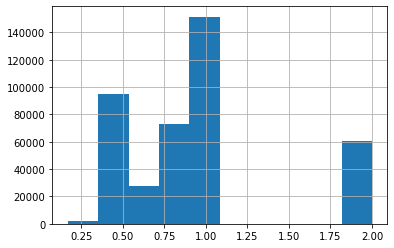

In [322]:
# Histogram of scores shows that most matches are pretty good (> 0.75)
cars['match_score'].hist()

In [332]:
cars.shape

(409234, 29)